In [94]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [95]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [96]:
np.random.seed(0)

***
Otwieranie danych
***

In [97]:
with open('german-traffic-signs/train.p','rb') as file:
  train_data = pickle.load(file)
with open('german-traffic-signs/valid.p','rb') as file:
  valid_data = pickle.load(file)
with open('german-traffic-signs/test.p','rb') as file:
  test_data = pickle.load(file)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [98]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [99]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

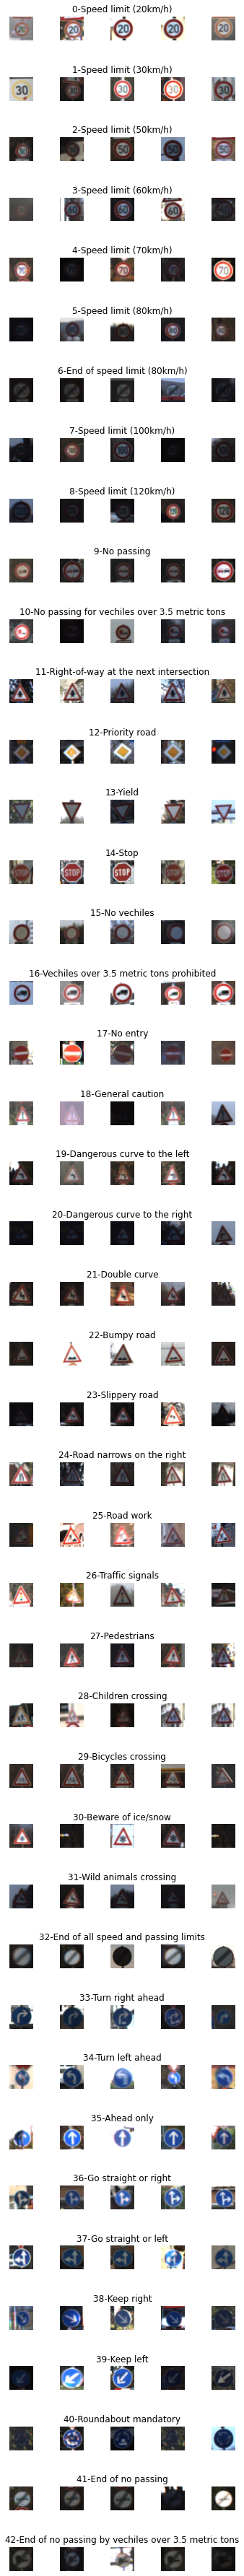

In [100]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-"+ row['SignName'])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


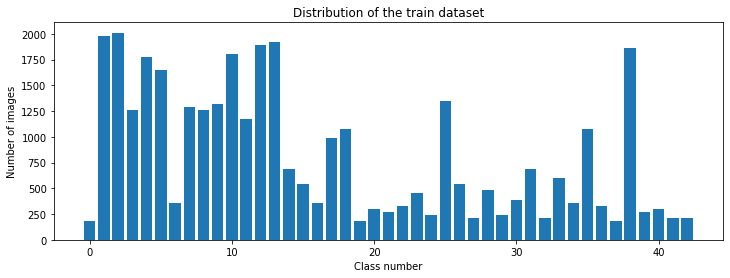

In [101]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


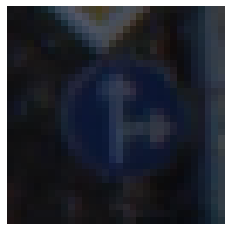

In [102]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

***
Image Preprocesing
***

(32, 32)


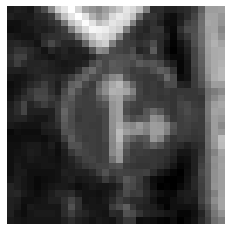

In [103]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

(32, 32)


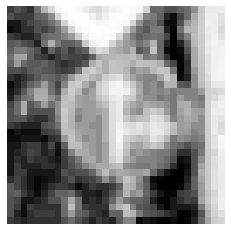

In [104]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

In [105]:
def preprocesing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocesing, X_train)))
X_val = np.array(list(map(preprocesing, X_val)))
X_test = np.array(list(map(preprocesing, X_test)))

(34799, 32, 32)


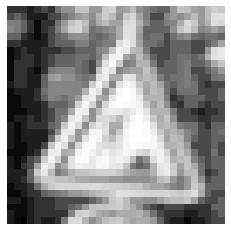

In [106]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap='gray')
plt.axis('off')
print(X_train.shape)

In [107]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [108]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [109]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

***
leNet Implementation
***

In [110]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5), input_shape = (32,32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def modified_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5), input_shape = (32,32,1), activation='relu'))
    model.add(Conv2D(60,(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [111]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [112]:
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 3s 32ms/step - loss: 2.3871 - accuracy: 0.3573 - val_loss: 0.7347 - val_accuracy: 0.8045
Epoch 2/10
87/87 [==============================] - 3s 29ms/step - loss: 0.6884 - accuracy: 0.7886 - val_loss: 0.2882 - val_accuracy: 0.9265
Epoch 3/10
87/87 [==============================] - 3s 29ms/step - loss: 0.3774 - accuracy: 0.8845 - val_loss: 0.1789 - val_accuracy: 0.9476
Epoch 4/10
87/87 [==============================] - 3s 29ms/step - loss: 0.2641 - accuracy: 0.9159 - val_loss: 0.1402 - val_accuracy: 0.9574
Epoch 5/10
87/87 [==============================] - 3s 29ms/step - loss: 0.2079 - accuracy: 0.9343 - val_loss: 0.1025 - val_accuracy: 0.9719
Epoch 6/10
87/87 [==============================] - 3s 29ms/step - loss: 0.1717 - accuracy: 0.9463 - val_loss: 0.1016 - val_accuracy: 0.9685
Epoch 7/10
87/87 [==============================] - 3s 30ms/step - loss: 0.1482 - accuracy: 0.9545 - val_loss: 0.0820 - val_accuracy: 0.9760
Epoch 8/10
87

Text(0.5, 0, 'Epoch')

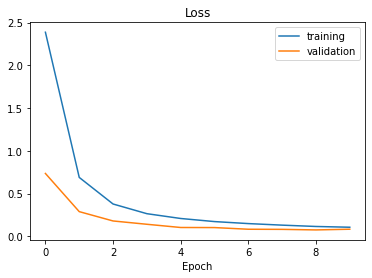

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

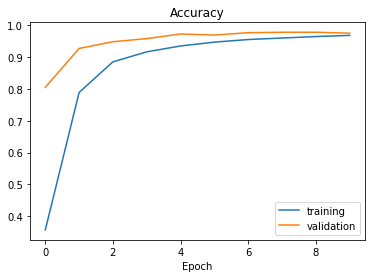

In [114]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel('Epoch')

In [115]:
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

Test score:  0.13468389213085175
Test accuracy:  0.9625495076179504


***
Testing Image
***

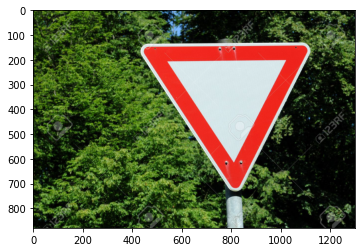

In [130]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


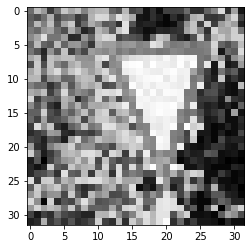

In [131]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [132]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [133]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=1)))

1/1 [==============================] - 0s 17ms/step
predicted sign: [2]
